In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

from functorch import vmap

import torchvision

import torchvision.transforms as transforms
import torchvision.transforms.functional as FN

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns

import tensorflow as tf

_ = torch.manual_seed(42)

2022-12-26 13:54:02.779699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 13:54:03.421721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-26 13:54:03.421779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-26 13:54:03.421787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Create useful directories
We will first create all useful directories used to store figures, datas and models

In [2]:
!mkdir -p ../data
!mkdir -p ../figures
!mkdir -p ../models

# Helper functions

Here are the implementation of some usefull functions

In [3]:
def saveModel(model, model_name, date=True):    
    if date: filename = f'../models/{model_name}_{datetime.now().strftime("%Y_%m_%d__%H_%M")})'
    else: filename = f'../models/{model_name}'
    
    torch.save(model.state_dict(), filename)

In [4]:
def loadModel(model, model_name):
    model.load_state_dict(torch.load(f'../models/{model_name}'))
    model.eval()
    return model

In [5]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=None, 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 filename=None):
    x,y = panelshape
    if figsize is None: figsize = (3*y, 3*x)
    n_imgs = min(len(imgs), n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if filename is not None: plt.savefig(f"{filename}.png")
    

In [6]:
# Divide dataset into batches

def divideInBatches(dataset, batch_size):
    # Train set
    n_batches = np.ceil(len(dataset)/batch_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader, n_batches,

In [7]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [8]:
def showimg(img, ax=None, shape=(28, 28), cmap='gray', title="", fontsize=15, axis=False, savefig=True, savedir=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and savedir is not None: plt.savefig(f"{filename}{savedir}.png")

In [9]:
device = chooseDevice()

GPU available via cuda


# Define datasets
We first download the fashionMNIST dataset using the dataset module of the pytorch library.
Then we reduce the model to 20% of its original size to have a lowerbound for our data augmentation performances.

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

full_train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
full_train_set_size = len(full_train_set)

In [11]:
reduction_factor = 0.05

idxs = np.random.choice(np.arange(full_train_set_size), int(full_train_set_size*reduction_factor) ,replace=False)

# Normalize the data from [-1. to 1.]
reduced_data  = full_train_set.data[idxs].float()
reduced_data /= reduced_data.max() - reduced_data.min()
reduced_data  = 2. * reduced_data - 1.

reduced_labels = full_train_set.targets[idxs]

In [12]:
reduced_train_set = torch.utils.data.TensorDataset(reduced_data, reduced_labels)
reduced_train_set_size = len(reduced_data)

In [13]:
# Delete some, now, useless variables
del reduction_factor, idxs

In [14]:
batch_size = 32
n_classes = len(full_train_set.classes)

In [15]:
# Create base loader
full_train_loader,    full_train_n_batches    = divideInBatches(full_train_set, batch_size)
reduced_train_loader, reduced_train_n_batches = divideInBatches(reduced_train_set, batch_size)
test_loader,          test_n_batches          = divideInBatches(test_set, batch_size)

# Model definition
Here we will define the architecture of our models

## CNN model

In [16]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

## Generator model

In [17]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

# Training of the CNN

In [18]:
n_epoch_cnn = 20

In [19]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

In [20]:
def evaluate_raw_performances(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
                              losses_train, accuracies_train, accuracies_test, 
                              loss_function, optimizer, log=False):
    cnn.eval()
    for batch_id, (data, labels) in enumerate(train_loader):
        data = data.reshape((-1,1,28,28))
        data = data.to(device)
        labels = labels.to(device)

        pred = cnn(data)

        labels_pred, labels_prob, _ = cnn.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)

        loss = loss_function(labels_prob, target_prob)
        
        optimizer.zero_grad()
        
        losses_train[0] += loss.item()
        accuracies_train[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train[0] /= train_n_batches
    losses_train[0] /= train_n_batches

    cnn.eval()
    for batch_id, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        pred = cnn(data)

        labels_pred, _, _ = cnn.predictLabels(pred)

        accuracies_test[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test[0] /= test_n_batches
    if log:
        print(f"Accuracy during training: {accuracies_train[0]*100:.2f}%")
        print(f"Accuracy during test:     {accuracies_test[0]*100:.2f}%")
        print(f"Loss during training:     {losses_train[0]:.2f}")

In [21]:
def train_cnn(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
              losses_train, accuracies_train, accuracies_test, 
              loss_function, optimizer, n_epoch, retain_graph=False, log=False):
    # Training of the CNN
    for epoch in range(n_epoch):
        cnn.train()
        for batch_id, (data, labels) in enumerate(train_loader):
            data = data.reshape((-1,1,28,28))
            data = data.to(device)
            labels = labels.to(device)

            pred = cnn(data)

            labels_pred, labels_prob, _ = cnn.predictLabels(pred)

            target_prob = torch.zeros_like(labels_prob)
            for i,j in enumerate(labels):
                target_prob[i][j] = 1
            target_prob = target_prob.to(device)
            
            loss = loss_function(labels_prob, target_prob)
            loss.backward(retain_graph = retain_graph)
            optimizer.step()
            optimizer.zero_grad()
            losses_train[epoch + 1] += loss.item()
            accuracies_train[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_train[epoch + 1] /= train_n_batches
        losses_train[epoch + 1] /= train_n_batches

        cnn.eval()
        for batch_id, (real, labels) in enumerate(test_loader):
            real = real.to(device)
            labels = labels.to(device)
            pred = cnn(real)

            labels_pred, _, _ = cnn.predictLabels(pred)

            accuracies_test[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_test[epoch + 1] /= test_n_batches
        if log:
            print(f"Epoch [{epoch + 1:2d}/{n_epoch:2d}] \
                    Accuracy: {accuracies_test[epoch + 1]:.4f} \
                    Loss:     {losses_train[epoch + 1]:.4f}")

## Train CNN on full data set

In [139]:
cnn_full = CNN(n_classes).to(device=device)

In [140]:
# Loss function for the CNN
loss_function_cnn_full = nn.CrossEntropyLoss()

In [141]:
# Adam optimization parameters
lr_cnn_full = 0.001
betas_cnn_full = (0.9, 0.999)

optimizer_cnn_full = torch.optim.Adam(cnn_full.parameters(), lr=lr_cnn_full, betas = betas_cnn_full)

In [142]:
%%time

# Error metrics at initialisation

losses_train_cnn_full     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_full = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_full  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
                          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
                          loss_function_cnn_full, optimizer_cnn_full)
print()


CPU times: user 14.2 s, sys: 8.71 ms, total: 14.2 s
Wall time: 13 s


In [143]:
%%time
train_cnn(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
          loss_function_cnn_full, optimizer_cnn_full,n_epoch_cnn)

print()
torch.cuda.empty_cache() 


CPU times: user 1min 21s, sys: 120 ms, total: 1min 21s
Wall time: -2.38e+12 ns


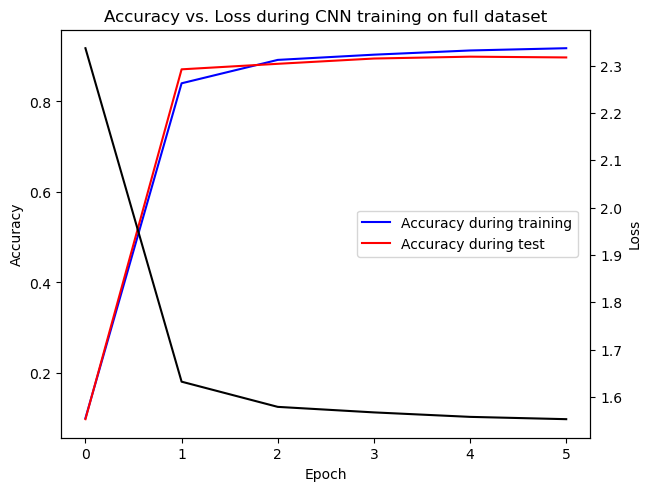

In [144]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on full dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs, accuracies_train_cnn_full, c='blue', label = "Accuracy during training")
ax1.plot(epochs, accuracies_test_cnn_full, c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs, losses_train_cnn_full,c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_full.png")

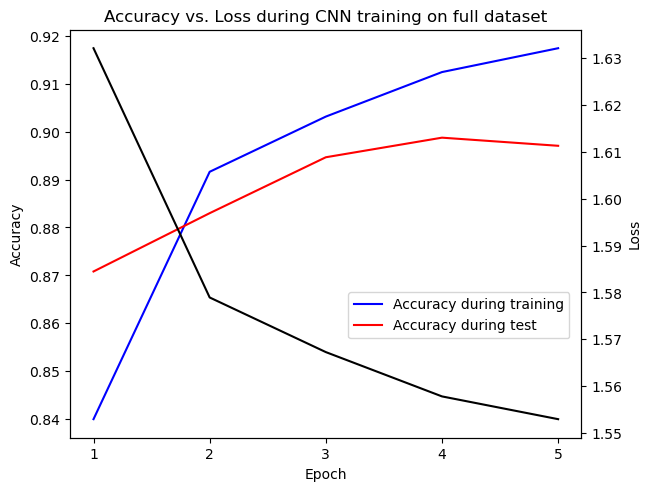

In [145]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on full dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs[1:], accuracies_train_cnn_full[1:], c='blue', label = "Accuracy during training")
ax1.plot(epochs[1:], accuracies_test_cnn_full[1:], c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs[1:], losses_train_cnn_full[1:],c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.3))

plt.savefig("../figures/CNN_metrics_full_cropped.png")

## Train CNN on reduced data set

In [146]:
cnn_reduced = CNN(n_classes).to(device=device)

In [147]:
# Loss function for the CNN
loss_function_cnn_reduced = nn.CrossEntropyLoss()

In [148]:
# Adam optimization parameters
lr_cnn_reduced = 0.001
betas_cnn_reduced = (0.9, 0.999)

optimizer_cnn_reduced = torch.optim.Adam(cnn_reduced.parameters(), lr=lr_cnn_reduced, betas = betas_cnn_reduced)

In [149]:
%%time

# Error metrics at initialisation

losses_train_cnn_reduced     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_reduced = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_reduced  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
                          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
                          loss_function_cnn_reduced, optimizer_cnn_reduced)

print()


CPU times: user 1.88 s, sys: 7.95 ms, total: 1.89 s
Wall time: 1.9 s


In [150]:
%%time
train_cnn(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
          loss_function_cnn_reduced, optimizer_cnn_reduced,n_epoch_cnn)

print()
torch.cuda.empty_cache() 


CPU times: user 10 s, sys: 4.55 ms, total: 10 s
Wall time: 10.1 s


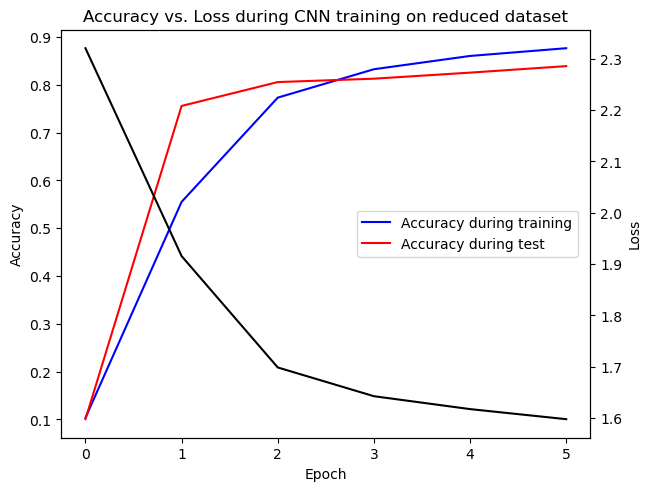

In [151]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax1.set_xlabel('Epoch')


ax1.plot(epochs, accuracies_train_cnn_reduced, c='blue', label = "Accuracy during training")
ax1.plot(epochs, accuracies_test_cnn_reduced, c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs, losses_train_cnn_reduced,c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_reduced.png")

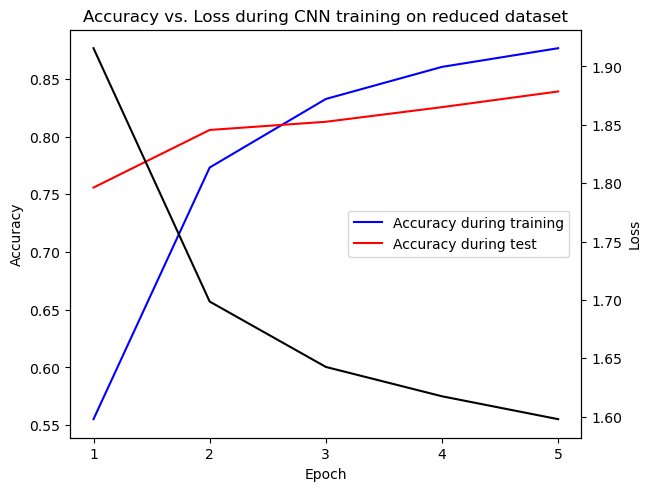

In [152]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax1 = plt.subplots(constrained_layout=True)
ax1.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax1.set_xlabel('Epoch')

ax1.plot(epochs[1:], accuracies_train_cnn_reduced[1:], c='blue', label = "Accuracy during training")
ax1.plot(epochs[1:], accuracies_test_cnn_reduced[1:], c='red', label = "Accuracy during test")

ax2 = ax1.twinx()
ax2.plot(epochs[1:], losses_train_cnn_reduced[1:],c = 'black', label = "Loss during train")

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc= 7, bbox_to_anchor=(.99,.5))

plt.savefig("../figures/CNN_metrics_reduced_cropped.png")

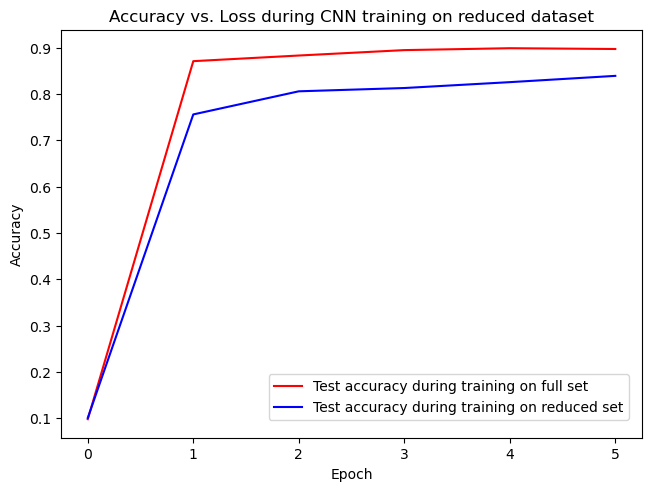

In [153]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax.set_xlabel('Epoch')

ax.plot(epochs, accuracies_test_cnn_full, c='red', label = "Test accuracy during training on full set")
ax.plot(epochs, accuracies_test_cnn_reduced, c='blue', label = "Test accuracy during training on reduced set")

ax.set_ylabel('Accuracy')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend(loc= 7, bbox_to_anchor=(.99,.1))

plt.savefig("../figures/CNN_metrics_bounds.png")

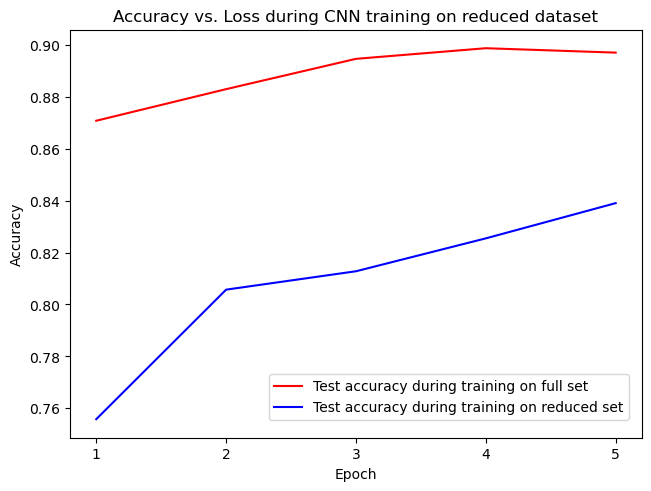

In [154]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Accuracy vs. Loss during CNN training on reduced dataset')
ax.set_xlabel('Epoch')

ax.plot(epochs[1:], accuracies_test_cnn_full[1:], c='red', label = "Test accuracy during training on full set")
ax.plot(epochs[1:], accuracies_test_cnn_reduced[1:], c='blue', label = "Test accuracy during training on reduced set")

ax.set_ylabel('Accuracy')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.legend(loc= 7, bbox_to_anchor=(.99,.1))

plt.savefig("../figures/CNN_metrics_bounds_cropped.png")

# Data augmentation
In this section we will explore mutliple data augmentation techniques and observe their effect on the CNN models

In [97]:
n_epoch_cnn = 5

## Rotation

In [34]:
def rotateimgs(imgs, angle, random=True):
    if random: 
        def _rotate(img, angle):
            angle = np.random.rand() * 2. * angle - angle
            return FN.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR, fill=-1)
    else:
        def _rotate(img, angle):
            return FN.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR, fill=-1)
        
    return torch.vstack([_rotate(img, angle) for img in imgs.split(1)])

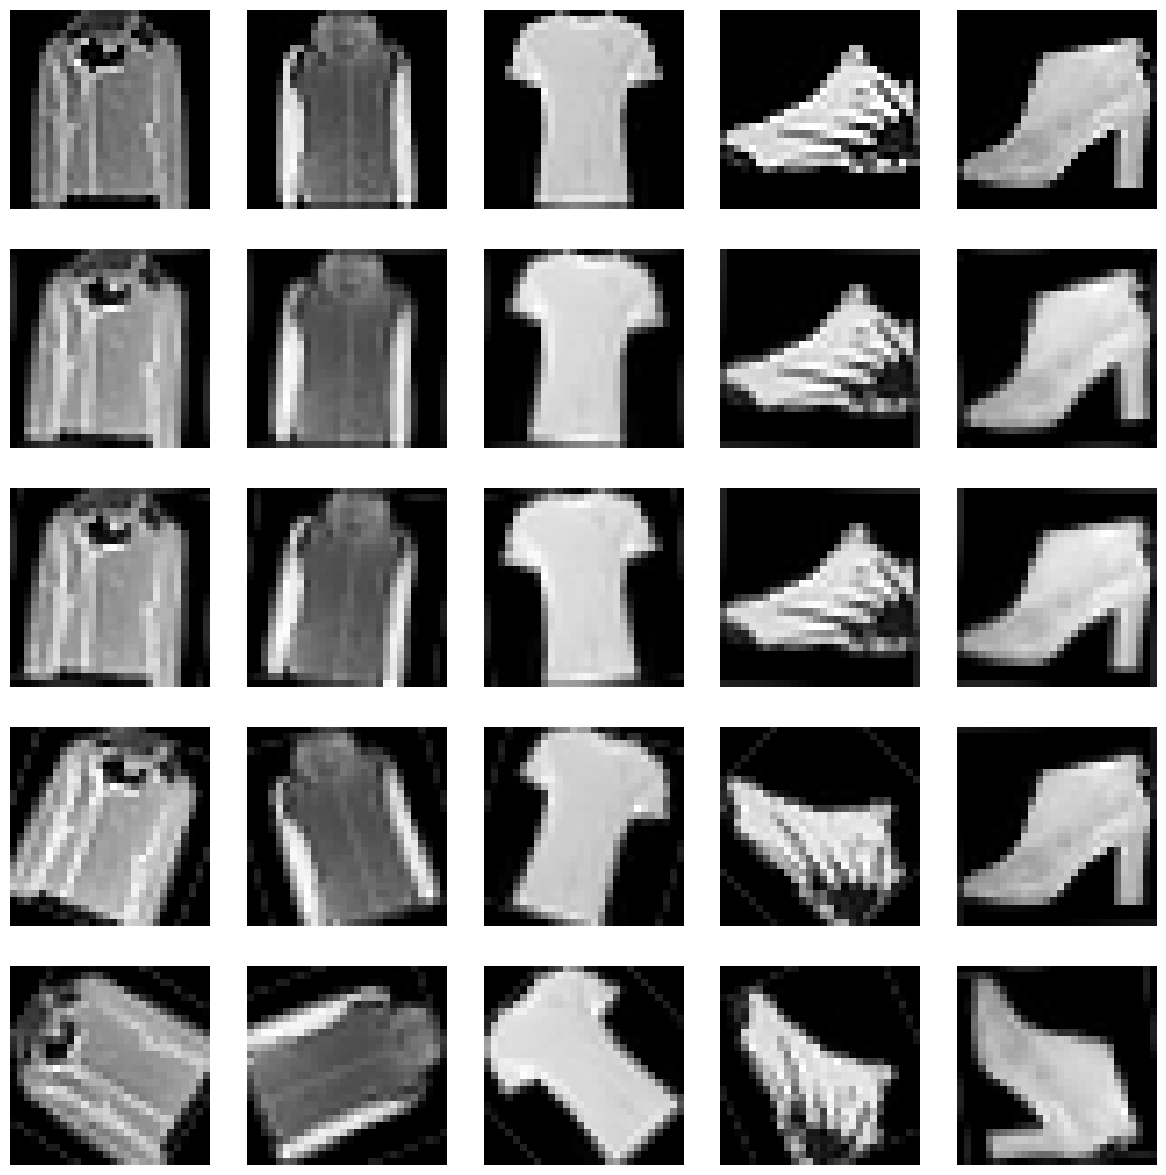

In [35]:
data = np.vstack((reduced_data[:5], 
                  rotateimgs(reduced_data[:5], 5), 
                  rotateimgs(reduced_data[:5],10), 
                  rotateimgs(reduced_data[:5],45), 
                  rotateimgs(reduced_data[:5],90)))

showimgpanel(data,25, (5,5), filename="../figures/rotation_example")

In [57]:
def training_rotation_n(data, labels, angle, aug_ratio, n_iter):
    print(f"Data augmented by {(100 * aug_ratio ):2.2f}% with rotation of {angle:2.2f}° max")
    results = [() for i in range(n_iter)]
    for i in range(n_iter):
        results[i] = training_rotation(data, labels, angle, aug_ratio)
    return results
    
def training_rotation(data, labels, angle, aug_ratio):
    losses_train_cnn_rot     = np.zeros(n_epoch_cnn+1)
    accuracies_train_cnn_rot = np.zeros(n_epoch_cnn+1)
    accuracies_test_cnn_rot  = np.zeros(n_epoch_cnn+1)
 
    rot_data = torch.clone(reduced_data).to(device)
    rot_labels = torch.clone(reduced_labels).to(device)
    
    n_new_data = int(aug_ratio * len(reduced_data)//n_classes)
    
    for label in range(n_classes):
        indices = np.arange(len(labels))[(labels == label)]
        indices = np.random.choice(indices, n_new_data)
        
        rot_data = torch.vstack((rot_data, rotateimgs(data[indices], angle).to(device)))
        rot_labels = torch.hstack((rot_labels, (label * torch.ones(n_new_data).int()).to(device)))
    
    rot_train_set = torch.utils.data.TensorDataset(rot_data, rot_labels)
    rot_train_set_size = len(rot_data)
    
    rot_train_loader, rot_train_n_batches = divideInBatches(rot_train_set, batch_size)
    
    
    cnn_rot = CNN(n_classes).to(device=device)
    
    # Loss function for the CNN
    loss_function_cnn_rot = nn.CrossEntropyLoss()
    
    # Adam optimization parameters
    lr_cnn_rot = 0.001
    betas_cnn_rot = (0.9, 0.999)

    optimizer_cnn_rot = torch.optim.Adam(cnn_rot.parameters(), lr=lr_cnn_rot, betas = betas_cnn_rot)
    
    evaluate_raw_performances(cnn_rot, rot_train_loader, test_loader, rot_train_n_batches, test_n_batches,
                              losses_train_cnn_rot, accuracies_train_cnn_rot, accuracies_test_cnn_rot, 
                              loss_function_cnn_rot, optimizer_cnn_rot, log=False)
    
    train_cnn(cnn_rot, rot_train_loader, test_loader, rot_train_n_batches, test_n_batches,
              losses_train_cnn_rot, accuracies_train_cnn_rot, accuracies_test_cnn_rot, 
              loss_function_cnn_rot, optimizer_cnn_rot, n_epoch_cnn, log=False)
    
    return losses_train_cnn_rot, accuracies_train_cnn_rot, accuracies_test_cnn_rot

In [60]:
augmentation_ratios = np.linspace(0.0, 0.5, 6)
angles = np.array((5, 10, 15, 30))
results_rot = [[training_rotation_n(reduced_data, reduced_labels, angle, ratio, 5)
                for angle in angles]
               for ratio in augmentation_ratios[1:]]

Data augmented by 10.00% with rotation of 5.00° max
Data augmented by 10.00% with rotation of 10.00° max
Data augmented by 10.00% with rotation of 15.00° max
Data augmented by 10.00% with rotation of 30.00° max
Data augmented by 20.00% with rotation of 5.00° max
Data augmented by 20.00% with rotation of 10.00° max
Data augmented by 20.00% with rotation of 15.00° max
Data augmented by 20.00% with rotation of 30.00° max
Data augmented by 30.00% with rotation of 5.00° max
Data augmented by 30.00% with rotation of 10.00° max
Data augmented by 30.00% with rotation of 15.00° max
Data augmented by 30.00% with rotation of 30.00° max
Data augmented by 40.00% with rotation of 5.00° max
Data augmented by 40.00% with rotation of 10.00° max
Data augmented by 40.00% with rotation of 15.00° max
Data augmented by 40.00% with rotation of 30.00° max
Data augmented by 50.00% with rotation of 5.00° max
Data augmented by 50.00% with rotation of 10.00° max
Data augmented by 50.00% with rotation of 15.00° ma

In [119]:
losses_train_cnn_rot_avg=[[np.mean([np.min(result_iter[0]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_rot]
losses_train_cnn_rot_loss_avg= np.array(accuracies_train_cnn_loss_avg)

accuracies_train_cnn_rot_avg=[[np.mean([np.max(result_iter[1]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_rot]
accuracies_train_cnn_rot_avg= np.array(accuracies_train_cnn_rot_avg)

accuracies_test_cnn_rot_avg=[[np.mean([np.max(result_iter[2]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_rot]
accuracies_test_cnn_rot_avg= np.array(accuracies_test_cnn_rot_avg)

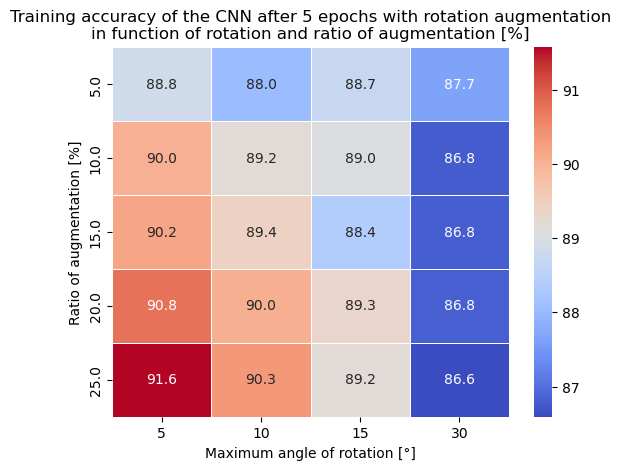

In [105]:
ax = sns.heatmap(accuracies_train_cnn_rot_avg*100, linewidth=0.5, annot=True, fmt=".1f", cmap='coolwarm')

ax.set_title("Training accuracy of the CNN after 5 epochs with rotation augmentation\nin function of rotation and ratio of augmentation [%]")

ax.set_ylabel("Ratio of augmentation [%]")
ax.set_yticklabels(np.round(augmentation_ratios[1:6]*100))

ax.set_xlabel("Maximum angle of rotation [°]")
ax.set_xticklabels(angles)

plt.savefig(f"../figures/Rotation_augmentation_accuracies_angle_ratio_training.png")

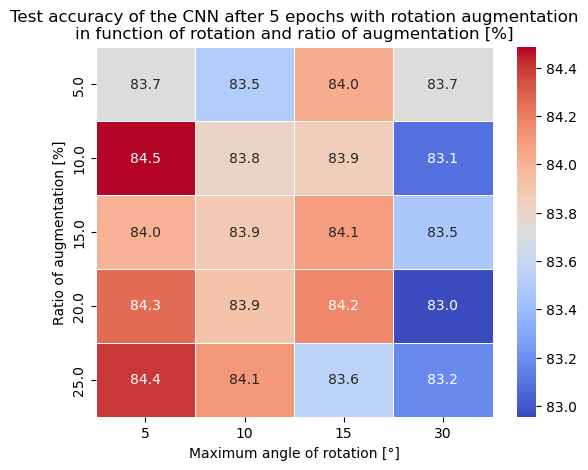

In [106]:
ax = sns.heatmap(accuracies_test_cnn_rot_avg*100, linewidth=0.5, annot=True, fmt=".1f", cmap='coolwarm')

ax.set_title("Test accuracy of the CNN after 5 epochs with rotation augmentation\nin function of rotation and ratio of augmentation [%]")

ax.set_ylabel("Ratio of augmentation [%]")
ax.set_yticklabels(np.round(augmentation_ratios[1:6]*100))

ax.set_xlabel("Maximum angle of rotation [°]")
ax.set_xticklabels(angles)

plt.savefig(f"../figures/Rotation_augmentation_accuracies_angle_ratio_test.png")

## Flipping images

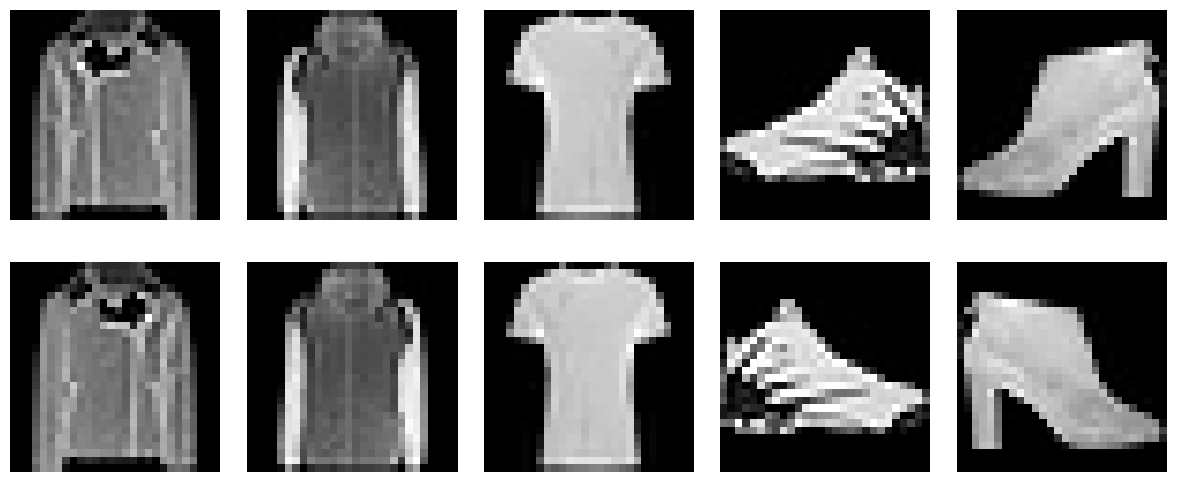

In [99]:
data = np.vstack((reduced_data[:5], 
                  torch.flip(reduced_data[:5], (2,))))
showimgpanel(data ,10 ,(2,5) , filename="../figures/flip_example")

In [100]:
def training_flip_n(data, labels, aug_ratio, n_iter):
    print(f"Data augmented by {aug_ratio * 100:2.2f}%")
    results = [() for i in range(n_iter)]
    for i in range(n_iter):
        results[i] = training_flip(data, labels, aug_ratio)
    return results
    
def training_flip(data, labels, aug_ratio):
    losses_train_cnn_flip     = np.zeros(n_epoch_cnn+1)
    accuracies_train_cnn_flip = np.zeros(n_epoch_cnn+1)
    accuracies_test_cnn_flip  = np.zeros(n_epoch_cnn+1)
 
    flip_data = torch.clone(reduced_data).to(device)
    flip_labels = torch.clone(reduced_labels).to(device)
    
    n_new_data = int(aug_ratio * len(reduced_data)//n_classes)
    
    for label in range(n_classes):
        indices = np.arange(len(labels))[(labels == label)]
        indices = np.random.choice(indices, n_new_data)
        
        flip_data = torch.vstack((flip_data, torch.flip(data[indices], (2,)).to(device)))
        flip_labels = torch.hstack((flip_labels, (label * torch.ones(n_new_data).int()).to(device)))
    
    flip_train_set = torch.utils.data.TensorDataset(flip_data, flip_labels)
    flip_train_set_size = len(flip_data)
    
    flip_train_loader, flip_train_n_batches = divideInBatches(flip_train_set, batch_size)
    
    
    cnn_flip = CNN(n_classes).to(device=device)
    
    # Loss function for the CNN
    loss_function_cnn_flip = nn.CrossEntropyLoss()
    
    # Adam optimization parameters
    lr_cnn_flip = 0.001
    betas_cnn_flip = (0.9, 0.999)

    optimizer_cnn_flip = torch.optim.Adam(cnn_flip.parameters(), lr=lr_cnn_flip, betas = betas_cnn_flip)
    
    evaluate_raw_performances(cnn_flip, flip_train_loader, test_loader, flip_train_n_batches, test_n_batches,
                              losses_train_cnn_flip, accuracies_train_cnn_flip, accuracies_test_cnn_flip, 
                              loss_function_cnn_flip, optimizer_cnn_flip, log=False)
    
    train_cnn(cnn_flip, flip_train_loader, test_loader, flip_train_n_batches, test_n_batches,
              losses_train_cnn_flip, accuracies_train_cnn_flip, accuracies_test_cnn_flip, 
              loss_function_cnn_flip, optimizer_cnn_flip, n_epoch_cnn, log=False)
    
    return losses_train_cnn_flip, accuracies_train_cnn_flip, accuracies_test_cnn_flip

In [101]:
augmentation_ratios = np.linspace(0.0, 1., 21)

results_flip = [training_flip_n(reduced_data, reduced_labels, ratio, 5)
                for ratio in augmentation_ratios]

Data augmented by 0.00%
Data augmented by 5.00%
Data augmented by 10.00%
Data augmented by 15.00%
Data augmented by 20.00%
Data augmented by 25.00%
Data augmented by 30.00%
Data augmented by 35.00%
Data augmented by 40.00%
Data augmented by 45.00%
Data augmented by 50.00%
Data augmented by 55.00%
Data augmented by 60.00%
Data augmented by 65.00%
Data augmented by 70.00%
Data augmented by 75.00%
Data augmented by 80.00%
Data augmented by 85.00%
Data augmented by 90.00%
Data augmented by 95.00%
Data augmented by 100.00%


In [107]:
accuracies_train_cnn_flip_avg = [np.mean([np.max(result_iter[1]) 
                                          for result_iter in result_ratio]) 
                                 for result_ratio in results_flip]
accuracies_train_cnn_flip_avg = np.array(accuracies_train_cnn_flip_avg)

accuracies_test_cnn_flip_avg = [np.mean([np.max(result_iter[2]) 
                                         for result_iter in result_ratio]) 
                                for result_ratio in results_flip]
accuracies_test_cnn_flip_avg = np.array(accuracies_test_cnn_flip_avg)

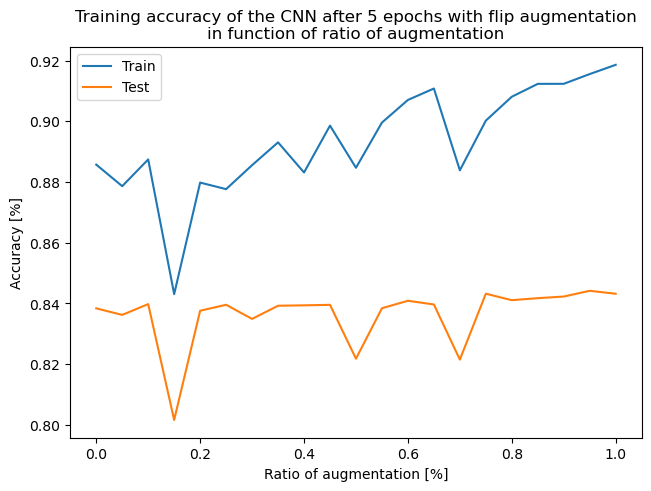

In [111]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(augmentation_ratios, accuracies_train_cnn_flip_avg, label="Train")
ax.plot(augmentation_ratios, accuracies_test_cnn_flip_avg, label="Test")

ax.set_title("Training accuracy of the CNN after 5 epochs with flip augmentation\nin function of ratio of augmentation")

ax.set_ylabel("Accuracy [%]")

ax.set_xlabel("Ratio of augmentation [%]")

ax.legend()

plt.savefig(f"../figures/Flip_augmentation_accuracies_ratio.png")

## Adding noise

In [113]:
def noiseimgs(imgs, val, mode='uniform', random=True):
    if mode=='uniform':
        noise = torch.rand_like(imgs) * 2. * val - val
    elif mode=='normal':
        noise = torch.randn_like(imgs) * 2. * val - val
    else:
        print("Mode not implemented, uniform used instead.")
        noise = torch.rand_like(imgs) * 2. * val - val
        
    tensor = imgs + noise
    
    tensor[tensor >  1.] =  1.
    tensor[tensor < -1.] = -1.
    
    return tensor

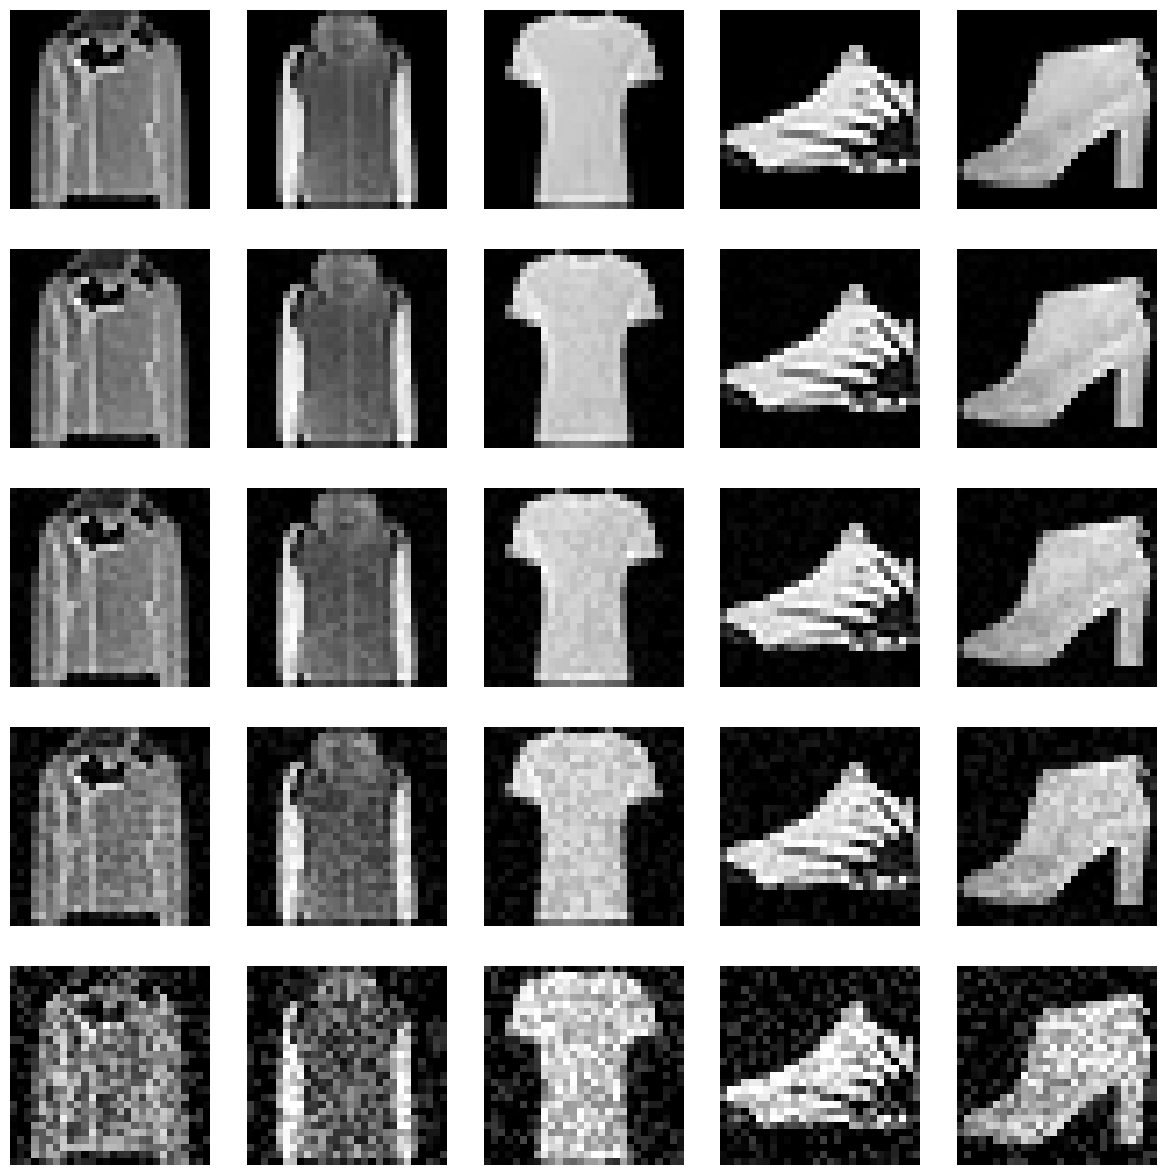

In [114]:
data = np.vstack((reduced_data[:5], 
                  noiseimgs(reduced_data[:5], 0.05), 
                  noiseimgs(reduced_data[:5], 0.1), 
                  noiseimgs(reduced_data[:5], 0.2), 
                  noiseimgs(reduced_data[:5], 0.5)))

showimgpanel(data,25,(5,5), filename="../figures/noise_example")

In [117]:
def training_noise_n(data, labels, val, aug_ratio, n_iter):
    print(f"Data augmented by {aug_ratio * 100:2.2f}% with maximum noise of {val:2.2f}")
    results = [() for i in range(n_iter)]
    for i in range(n_iter):
        results[i] = training_noise(data, labels, val, aug_ratio)
    return results
    f
def training_noise(data, labels, val, aug_ratio):
    losses_train_cnn_noise     = np.zeros(n_epoch_cnn+1)
    accuracies_train_cnn_noise = np.zeros(n_epoch_cnn+1)
    accuracies_test_cnn_noise  = np.zeros(n_epoch_cnn+1)
 
    noise_data = torch.clone(reduced_data).to(device)
    noise_labels = torch.clone(reduced_labels).to(device)
    
    n_new_data = int(aug_ratio * len(reduced_data)//n_classes)
    
    for label in range(n_classes):
        indices = np.arange(len(labels))[(labels == label)]
        indices = np.random.choice(indices, n_new_data)
        
        noise_data = torch.vstack((noise_data, noiseimgs(data[indices], val).to(device)))
        noise_labels = torch.hstack((noise_labels, (label * torch.ones(n_new_data).int()).to(device)))
        
    noise_train_set = torch.utils.data.TensorDataset(noise_data, noise_labels)
    noise_train_set_size = len(noise_data)
    
    noise_train_loader, noise_train_n_batches = divideInBatches(noise_train_set, batch_size)
    
    
    cnn_noise = CNN(n_classes).to(device=device)
    
    # Loss function for the CNN
    loss_function_cnn_noise = nn.CrossEntropyLoss()
    
    # Adam optimization parameters
    lr_cnn_noise = 0.001
    betas_cnn_noise = (0.9, 0.999)

    optimizer_cnn_noise = torch.optim.Adam(cnn_noise.parameters(), lr=lr_cnn_noise, betas = betas_cnn_noise)
    
    evaluate_raw_performances(cnn_noise, noise_train_loader, test_loader, noise_train_n_batches, test_n_batches,
                              losses_train_cnn_noise, accuracies_train_cnn_noise, accuracies_test_cnn_noise, 
                              loss_function_cnn_noise, optimizer_cnn_noise, log=False)
    
    train_cnn(cnn_noise, noise_train_loader, test_loader, noise_train_n_batches, test_n_batches,
              losses_train_cnn_noise, accuracies_train_cnn_noise, accuracies_test_cnn_noise, 
              loss_function_cnn_noise, optimizer_cnn_noise, n_epoch_cnn, log=False)
    
    return losses_train_cnn_noise, accuracies_train_cnn_noise, accuracies_test_cnn_noise

In [118]:
augmentation_ratios = np.linspace(0.0, 0.5, 6)
noises = np.array([0.05,0.1, 0.15, 0.2, 0.25])
results_noise = [[training_noise_n(reduced_data, reduced_labels, noise, ratio, 5)
                  for noise in noises]
                 for ratio in augmentation_ratios[1:]]

Data augmented by 10.00% with maximum noise of 0.05
Data augmented by 10.00% with maximum noise of 0.10
Data augmented by 10.00% with maximum noise of 0.15
Data augmented by 10.00% with maximum noise of 0.20
Data augmented by 10.00% with maximum noise of 0.25
Data augmented by 20.00% with maximum noise of 0.05
Data augmented by 20.00% with maximum noise of 0.10
Data augmented by 20.00% with maximum noise of 0.15
Data augmented by 20.00% with maximum noise of 0.20
Data augmented by 20.00% with maximum noise of 0.25
Data augmented by 30.00% with maximum noise of 0.05
Data augmented by 30.00% with maximum noise of 0.10
Data augmented by 30.00% with maximum noise of 0.15
Data augmented by 30.00% with maximum noise of 0.20
Data augmented by 30.00% with maximum noise of 0.25
Data augmented by 40.00% with maximum noise of 0.05
Data augmented by 40.00% with maximum noise of 0.10
Data augmented by 40.00% with maximum noise of 0.15
Data augmented by 40.00% with maximum noise of 0.20
Data augment

In [122]:
losses_train_cnn_noise_avg=[[np.mean([np.min(result_iter[0]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_noise]
losses_train_cnn_noise_loss_avg= np.array(accuracies_train_cnn_loss_avg)

accuracies_train_cnn_noise_avg=[[np.mean([np.max(result_iter[1]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_noise]
accuracies_train_cnn_noise_avg= np.array(accuracies_train_cnn_noise_avg)

accuracies_test_cnn_noise_avg=[[np.mean([np.max(result_iter[2]) 
                                        for result_iter in result_angle]) 
                               for result_angle in result_ratio]
                              for result_ratio in results_noise]
accuracies_test_cnn_noise_avg= np.array(accuracies_test_cnn_noise_avg)

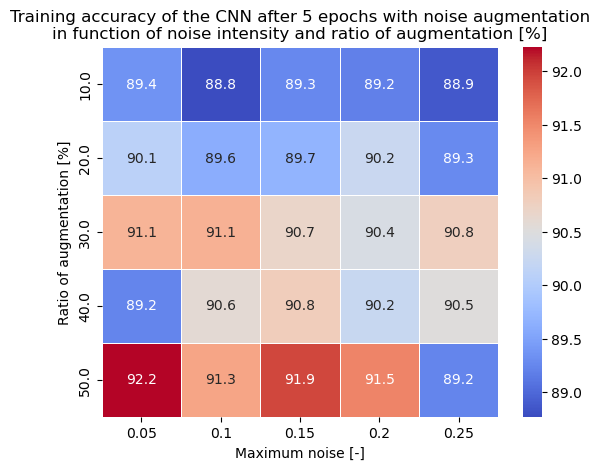

In [127]:
ax = sns.heatmap(accuracies_train_cnn_noise_avg*100, linewidth=0.5, annot=True, fmt=".1f", cmap='coolwarm')

ax.set_title("Training accuracy of the CNN after 5 epochs with noise augmentation\nin function of noise intensity and ratio of augmentation [%]")

ax.set_ylabel("Ratio of augmentation [%]")
ax.set_yticklabels(np.round(augmentation_ratios[1:]*100))

ax.set_xlabel("Maximum noise [-]")
ax.set_xticklabels(noises)

plt.savefig(f"../figures/Noise_augmentation_accuracies_val_ratio_training.png")

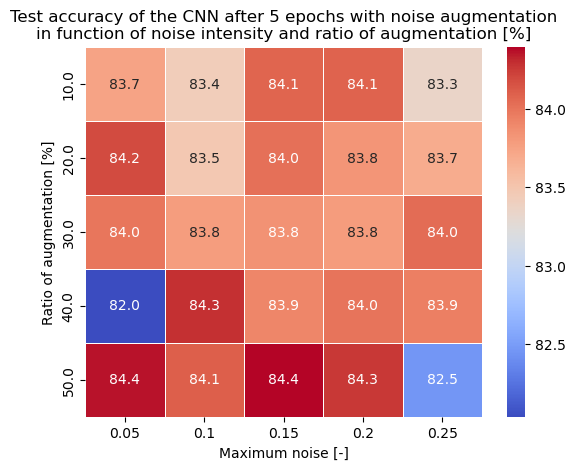

In [128]:
ax = sns.heatmap(accuracies_test_cnn_noise_avg*100, linewidth=0.5, annot=True, fmt=".1f", cmap='coolwarm')

ax.set_title("Test accuracy of the CNN after 5 epochs with noise augmentation\nin function of noise intensity and ratio of augmentation [%]")

ax.set_ylabel("Ratio of augmentation [%]")
ax.set_yticklabels(np.round(augmentation_ratios[1:6]*100))

ax.set_xlabel("Maximum noise [-]")
ax.set_xticklabels(noises)

plt.savefig(f"../figures/Noise_augmentation_accuracies_val_ratio_test.png")

## Synthetic Minority Over-sampling Technique (SMOTE)
SMOTE (Synthetic Minority Oversampling Technique) is a popular technique for oversampling in imbalanced data sets in machine learning. It is used to synthesize new minority class examples in order to increase the number of minority class instances and balance the class distribution.

The goal of SMOTE is to address the issue of imbalanced data sets, where one class (the minority class) is significantly underrepresented compared to the other class (the majority class). In such cases, machine learning algorithms can often have a biased learning towards the majority class, leading to poor performance on the minority class. By synthesizing new minority class examples, SMOTE helps to balance the class distribution and improve the performance of the model on the minority class.

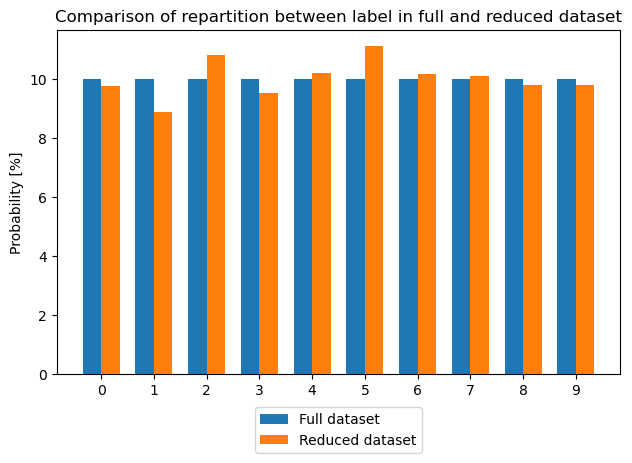

In [129]:
reduced_train_set.tensors[1]

n_full = np.zeros(n_classes)
n_reduced = np.zeros(n_classes)
for label in range(n_classes):
    n_full[label] = torch.sum((full_train_set.targets == label).int())
    n_reduced[label] = torch.sum((reduced_train_set.tensors[1] == label).int())

p_full = n_full/full_train_set_size
p_reduced = n_reduced/reduced_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x + width/2, p_reduced*100, width, label='Reduced dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.25))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_initial")
plt.show()


We can observe that the full fashion MNIST dataset is perfectly balanced. We are going to apply SMOTE methode to balance our reduced dataset.

In [130]:
smote_data = torch.clone(reduced_data)
smote_labels = torch.clone(reduced_labels)

In [131]:
n_max = int(np.max(n_reduced))

for label in range(n_classes):
    idxs = np.arange(reduced_train_set_size)[reduced_train_set.tensors[1]==label]
    
    n_missing = int(n_max-n_reduced[label])
    print(f"\nGenerating {n_missing:2d} images of label '{full_train_set.classes[label]}' with 10% of the set")
    for i in range(n_missing):
        idxs = np.random.choice(np.arange(n_classes), int(n_reduced[label]*0.1))
        smote_data = torch.vstack((smote_data, torch.mean(reduced_data[idxs], dim=0).reshape((1,28,28))))
        smote_labels = torch.hstack((smote_labels, torch.tensor([label])))


Generating 41 images of label 'T-shirt/top' with 10% of the set

Generating 67 images of label 'Trouser' with 10% of the set

Generating  9 images of label 'Pullover' with 10% of the set

Generating 48 images of label 'Dress' with 10% of the set

Generating 27 images of label 'Coat' with 10% of the set

Generating  0 images of label 'Sandal' with 10% of the set

Generating 28 images of label 'Shirt' with 10% of the set

Generating 30 images of label 'Sneaker' with 10% of the set

Generating 40 images of label 'Bag' with 10% of the set

Generating 40 images of label 'Ankle boot' with 10% of the set


In [132]:
smote_train_set = torch.utils.data.TensorDataset(smote_data, smote_labels)
smote_train_set_size = len(smote_data)

smote_train_loader, smote_train_n_batches = divideInBatches(smote_train_set, batch_size)

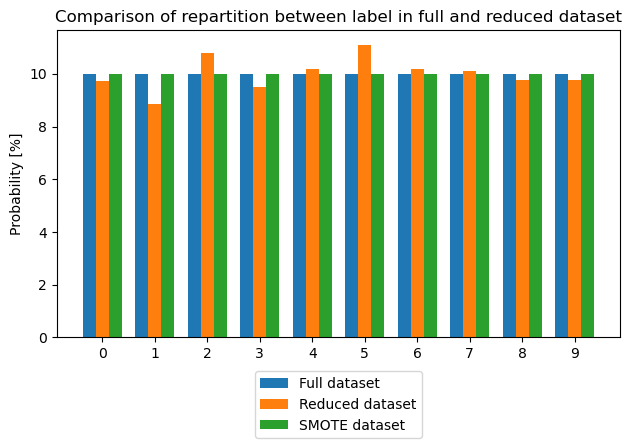

In [133]:
reduced_train_set.tensors[1]

n_smote = np.zeros(n_classes)
for label in range(n_classes):
    n_smote[label] = torch.sum((smote_labels == label).int())

p_smote = n_smote/smote_train_set_size

x = np.arange(n_classes)  # the label locations
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, p_full*100, width, label='Full dataset')
rects2 = ax.bar(x , p_reduced*100, width, label='Reduced dataset')
rects3 = ax.bar(x + width, p_smote*100, width, label='SMOTE dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability [%]')
ax.set_title(f'Comparison of repartition between label in full and reduced dataset')
ax.set_xticks(x, x)
ax.legend(loc='lower center',bbox_to_anchor=(.5,-.35))

fig.tight_layout()

plt.savefig("../figures/labels_repartition_smote")
plt.show()

The dataset obtained after SMOTE method is indeed balanced as we can see. This dataset does now contain:

In [134]:
print(f"{smote_train_set_size} records. It corresponds to an augmentation of +{100.*(smote_train_set_size/reduced_train_set_size-1.):.2f}% in comparison to the initial reduced dataset.")

3330 records. It corresponds to an augmentation of +11.00% in comparison to the initial reduced dataset.


In [135]:
cnn_smote = CNN(n_classes).to(device=device)
# Loss function for the CNN
loss_function_cnn_smote = nn.CrossEntropyLoss()
# Adam optimization parameters
lr_cnn_smote = 0.001
betas_cnn_smote = (0.9, 0.999)

optimizer_cnn_smote = torch.optim.Adam(cnn_smote.parameters(), lr=lr_cnn_smote, betas = betas_cnn_smote)

In [136]:
%%time

# Error metrics at initialisation

losses_train_cnn_smote     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_smote = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_smote  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
                          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
                          loss_function_cnn_smote, optimizer_cnn_smote)

print()


CPU times: user 1.89 s, sys: 7 µs, total: 1.89 s
Wall time: 1.74 s


In [137]:
%%time
train_cnn(cnn_smote, smote_train_loader, test_loader, smote_train_n_batches, test_n_batches,
          losses_train_cnn_smote, accuracies_train_cnn_smote, accuracies_test_cnn_smote, 
          loss_function_cnn_smote, optimizer_cnn_smote,n_epoch_cnn)

print()
torch.cuda.empty_cache() 

KeyboardInterrupt: 

NameError: name 'accuracies_test_cnn_reduced' is not defined

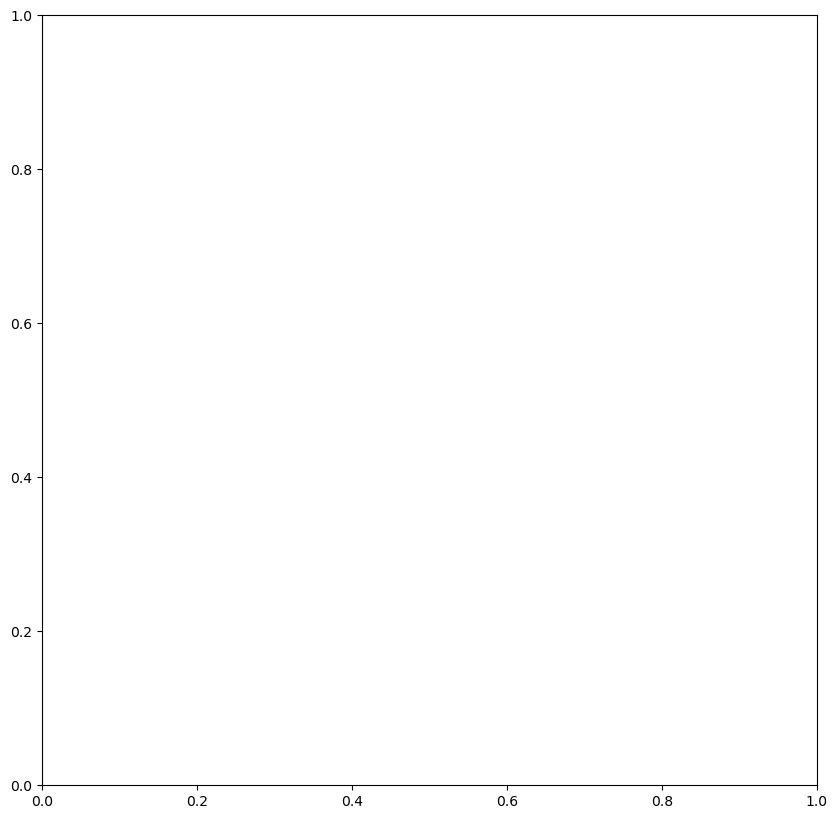

In [138]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig,  ax1= plt.subplots(1, 1, figsize=(10,10))

ax1.plot(epochs[1:], accuracies_test_cnn_reduced[1:], label = "Dataset reduced to 5%")
ax1.plot(epochs[1:], accuracies_test_cnn_smote[1:], label = "Dataset reduced to 5% with SMOTE balancing")
ax1.plot(epochs[1:], accuracies_test_cnn_full[1:], label = "Full dataset")
ax1.set_title('Accuracy of CNN during test')
ax1.set_xlabel('Epoch')
ax1.legend()

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.savefig("../figures/CNN_Accuracy_comparison_smote.png")

## GAN data augmentation
In this section we will augment the data using a GAN trained on the full data set.
The motivation is the apparition of powerfull general purpose image generation services such as DALL-E, Midjourney or Stable Diffusion, the most known.
This mean in the future, we might be able to augment the data using a GAN which was not trained using a reduced dataset.

We trained the GAN on another notebook (see http://localhost:8888/lab/tree/src/FashionMNIST_GAN_Training.ipynb). It consists of 10 GANs, one for each class.

In [ ]:
# Loading pretrained models
generators = [loadModel(Generator(100), f"Generator_50_class_{i:02d}")
              for i in range(n_classes)]

In [ ]:
generated = []
for i in range(n_classes):
    noise = torch.randn(100)
    generated.append(generators[i](noise).cpu().detach())

showimgpanel(generated, 9, (3,3))

In [ ]:
gen_ratios = np.linspace(.0,1, 21)

losses_train_cnn_gan     = [np.zeros(n_epoch_cnn+1) for i in range(len(gen_ratios))]
accuracies_train_cnn_gan = [np.zeros(n_epoch_cnn+1) for i in range(len(gen_ratios))]
accuracies_test_cnn_gan  = [np.zeros(n_epoch_cnn+1) for i in range(len(gen_ratios))]

for i, r in enumerate(gen_ratios):    
    print(f"Training with augmentation of {r*100:2.2f}%\n")
    gan_data = torch.clone(reduced_data).to(device)
    gan_labels = torch.clone(reduced_labels).to(device)
    
    n_new_data = int(r * len(reduced_data)//n_classes)

    for label in range(n_classes):
        dim_latent_space = generators[label].dim_latent_space
        g = generators[label](torch.randn((n_new_data, dim_latent_space))).detach()
        g = torch.squeeze(g).to(device)
        gan_data = torch.vstack((gan_data, g))
        gan_labels = torch.hstack((gan_labels, (label * torch.ones(n_new_data).int()).to(device)))
    
    gan_train_set = torch.utils.data.TensorDataset(gan_data, gan_labels)
    gan_train_set_size = len(gan_data)

    gan_train_loader, gan_train_n_batches = divideInBatches(gan_train_set, batch_size)
    
    
    cnn_gan = CNN(n_classes).to(device=device)
    
    # Loss function for the CNN
    loss_function_cnn_gan = nn.CrossEntropyLoss()
    
    # Adam optimization parameters
    lr_cnn_gan = 0.001
    betas_cnn_gan = (0.9, 0.999)

    optimizer_cnn_gan = torch.optim.Adam(cnn_gan.parameters(), lr=lr_cnn_gan, betas = betas_cnn_gan)
    
    evaluate_raw_performances(cnn_gan, gan_train_loader, test_loader, gan_train_n_batches, test_n_batches,
                              losses_train_cnn_gan[i], accuracies_train_cnn_gan[i], accuracies_test_cnn_gan[i], 
                              loss_function_cnn_gan, optimizer_cnn_gan)
    
    print()
    
    train_cnn(cnn_gan, gan_train_loader, test_loader, gan_train_n_batches, test_n_batches,
              losses_train_cnn_gan[i], accuracies_train_cnn_gan[i], accuracies_test_cnn_gan[i], 
              loss_function_cnn_gan, optimizer_cnn_gan, n_epoch_cnn)
    print()
    
torch.cuda.empty_cache() 

In [ ]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig,  (ax1,ax2,ax3)= plt.subplots(3, 1, figsize=(10,15))

for i, acc in enumerate(accuracies_test_cnn_gan):
    ax1.plot(epochs[1:], acc[1:], label = f"Augmented by {100*gen_ratios[i]:2.2f}%")
ax1.set_title('Accuracy of CNN during test')
ax1.set_xlabel('Epoch')
#ax1.legend()

for i, acc in enumerate(accuracies_train_cnn_gan):
    ax2.plot(epochs[1:], acc[1:], label = f"Augmented by {100*gen_ratios[i]:2.2f}%")
ax2.set_title('Accuracy of CNN during train')
ax2.set_xlabel('Epoch')
#ax2.legend()

for i, loss in enumerate(losses_train_cnn_gan):
    ax3.plot(epochs[1:], loss[1:], label = f"Augmented by {100*gen_ratios[i]:2.2f}%")
ax3.set_title('loss of CNN during train')
ax3.set_xlabel('Epoch')
#ax3.legend()


#plt.savefig("../figures/CNN_Accuracy_comparison_smote.png")

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(10,10))
ax.plot(gen_ratios*100, [np.median(acc) for acc in accuracies_test_cnn_gan])